# **Pipeline to Evaluate and Deploy Final Symbolism Model**

After fine-tuning our model using all 979 poems, this means that this evaluation is a post-hoc evaluation since our model has seen all possible poems. Next time in future pipelines, if we want to test generalization on unseen data, we can split the data beforehand into train_df and eval_df, fine-tune using only train_df, and then evaluate on eval_df. 

Since this is a proof-of-concept project and the first time doing an LLM, a post-hoc evaluation is okay to see a comparison of the two models.

**Load in dependencies**

In [32]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import openai
from collections import defaultdict
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import numpy as np
import ast

## **Model performance evaluation**

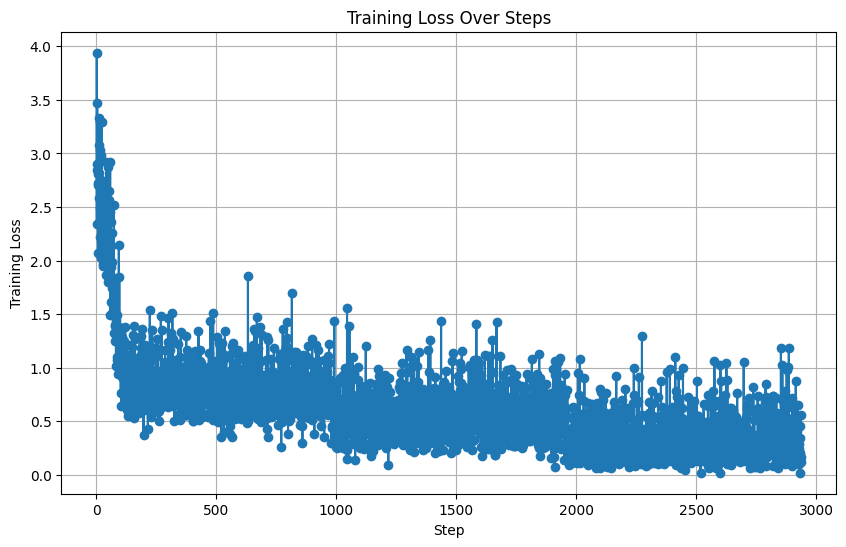

In [9]:
# Get fine-tune events - all steps
events = list(client.fine_tuning.jobs.list_events("ftjob-RoUd7fn1iAtUgvJr0Trd0v8J"))

steps = []
losses = []

for e in events:
    message = e.message
    match = re.search(r"Step (\d+)/\d+: training loss=([\d.]+)", message)
    if match:
        step = int(match.group(1))
        loss = float(match.group(2))
        steps.append(step)
        losses.append(loss)

# Plot it
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker="o")
plt.title("Training Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

It seems a little crowded so we will reduce it to every 50 steps

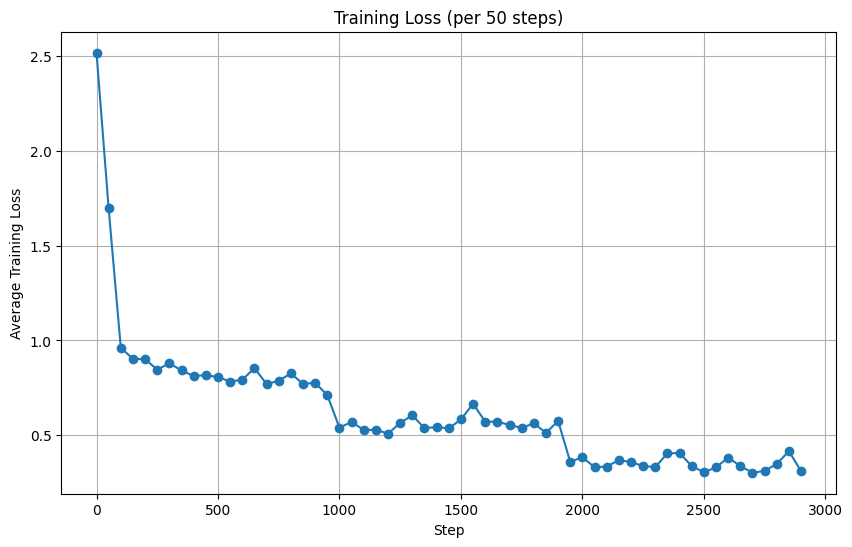

In [15]:
events = list(client.fine_tuning.jobs.list_events("ftjob-RoUd7fn1iAtUgvJr0Trd0v8J"))

step_loss_pairs = []

for e in events:
    message = e.message
    match = re.search(r"Step (\d+)/\d+: training loss=([\d.]+)", message)
    if match:
        step = int(match.group(1))
        loss = float(match.group(2))
        step_loss_pairs.append((step, loss))

# Group into intervlas of 50
binned_losses = defaultdict(list)

for step, loss in step_loss_pairs:
    bin_index = (step // 50) * 50
    binned_losses[bin_index].append(loss)

avg_steps = []
avg_losses = []

for step in sorted(binned_losses):
    avg_steps.append(step)
    avg_losses.append(sum(binned_losses[step]) / len(binned_losses[step]))

plt.figure(figsize=(10, 6))
plt.plot(avg_steps, avg_losses, marker='o')
plt.title("Training Loss (per 50 steps)")
plt.xlabel("Step")
plt.ylabel("Average Training Loss")
plt.grid(True)
plt.show()

**Post-hoc evaluation**

In [17]:
df = pd.read_csv("C:/Users/Marielle/OneDrive/Desktop/LLM Project/ocpoem_final_with_themes_cleaned.csv")

In [18]:
# Split subset for evaluation
eval_df = df.sample(frac=0.2, random_state=42).reset_index(drop=True) # We will use 20%

In [20]:
# Call the model
fine_tuned_model = "ft:gpt-3.5-turbo-0125:personal::C15qtfQm"

In [23]:
# Define the prompt
def get_themes_from_model(poem):
    prompt = (
        f"For the poem below, give me 5 symbolism themes as a JSON list.\n\n"
        f"\"{poem}\"\n\n"
        "Respond ONLY with a JSON array of themes, no explanations needed. "
        "Example: [\"theme1\", \"theme2\", \"theme3\", \"theme4\", \"theme5\"]"
    )

    response = client.chat.completions.create(
        model=fine_tuned_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that extracts symbolism themes from poems."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=300,
    )

    output = response.choices[0].message.content.strip()

    try:
        return json.loads(output)
    except json.JSONDecodeError:
        print(f"JSON decode error on poem: {poem[:30]}... Returning empty list")
        with open("bad_eval_responses.txt", "a", encoding="utf-8") as f:
            f.write(f"\n\nPOEM:\n{poem}\n\nRESPONSE:\n{output}")
        return []

In [24]:
# Apply to evaluation subset
eval_df["predicted_themes"] = eval_df["cleaned"].apply(get_themes_from_model)

#7:46pm

JSON decode error on poem: i can't help how i love i want... Returning empty list
JSON decode error on poem: comments note poem about frien... Returning empty list
JSON decode error on poem: i met a woman recently in a wa... Returning empty list
JSON decode error on poem: hello, everyone, may you pleas... Returning empty list
JSON decode error on poem: do i even know what love is? f... Returning empty list
JSON decode error on poem: the night unfurls like a velve... Returning empty list
JSON decode error on poem: mouth sounds and bl00d shed th... Returning empty list
JSON decode error on poem: i wrote this during a bit of a... Returning empty list
JSON decode error on poem: all i see? gaggles of humans l... Returning empty list
JSON decode error on poem: nothing makes sense anymore i'... Returning empty list


In [25]:
eval_df.to_csv("eval_with_predicted_themes.csv", index=False)

**Dealing with poem errors**

For the poems that returned an empty list, there's still valuable information for analysis. This could indicate that the model cannot work with that poem since it is an older version. Because of that, we will just add ['no_theme', 'no_theme', 'no_theme', 'no_theme', 'no_theme',] to that row with empty lists.

This can just be manually done by opening the eval_with_predicted_themes.csv

**Evaluation metrics**

In [45]:
eval_df = pd.read_csv("C:/Users/Marielle/OneDrive/Desktop/LLM Project/eval_with_predicted_themes.csv")

# Convert stringified lists to actual lists
eval_df["themes"] = eval_df["themes"].apply(ast.literal_eval)
eval_df["predicted_themes"] = eval_df["predicted_themes"].apply(ast.literal_eval)

In [46]:
# Exact Jaccard Similarity (treat phrases as atomic items) - STRICT
def jaccard_exact(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    if not set1 and not set2:
        return 1.0
    return len(set1 & set2) / len(set1 | set2)

# Token-level Jaccard Similarity - MORE FORGIVING
def jaccard_token(list1, list2):
    tokens1 = set(" ".join(list1).lower().split())
    tokens2 = set(" ".join(list2).lower().split())
    if not tokens1 and not tokens2:
        return 1.0
    return len(tokens1 & tokens2) / len(tokens1 | tokens2)

# Precision and Recall based on exact string match
def precision_recall(preds, truth):
    preds = set(preds)
    truth = set(truth)
    true_positives = len(preds & truth)
    precision = true_positives / len(preds) if preds else 0.0
    recall = true_positives / len(truth) if truth else 0.0
    return precision, recall

In [47]:
# Lists to collect scores
exact_jaccard_scores = []
token_jaccard_scores = []
precisions = []
recalls = []

for _, row in eval_df.iterrows():
    true_themes = row["themes"]
    pred_themes = row["predicted_themes"]
    
    exact_jaccard_scores.append(jaccard_exact(true_themes, pred_themes))
    token_jaccard_scores.append(jaccard_token(true_themes, pred_themes))
    
    p, r = precision_recall(pred_themes, true_themes)
    precisions.append(p)
    recalls.append(r)

# Add metrics to DataFrame (optional)
eval_df["exact_jaccard"] = exact_jaccard_scores
eval_df["token_jaccard"] = token_jaccard_scores
eval_df["precision"] = precisions
eval_df["recall"] = recalls

In [48]:
# Print aggregate metrics
print("Evaluation Summary:")
print(f"Average Exact Jaccard: {np.mean(exact_jaccard_scores):.4f}")
print(f"Average Token Jaccard: {np.mean(token_jaccard_scores):.4f}")
print(f"Average Precision:     {np.mean(precisions):.4f}")
print(f"Average Recall:        {np.mean(recalls):.4f}")

Evaluation Summary:
Average Exact Jaccard: 0.1420
Average Token Jaccard: 0.4183
Average Precision:     0.2020
Average Recall:        0.2020


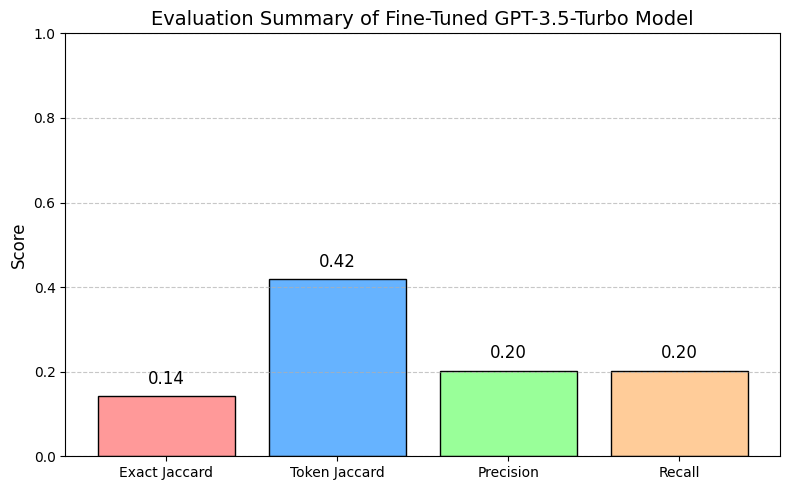

In [49]:
# Visualize results

metrics = {
    "Exact Jaccard": 0.1420,
    "Token Jaccard": 0.4183,
    "Precision":     0.2020,
    "Recall":        0.2020
}

colors = ["#FF9999", "#66B3FF", "#99FF99", "#FFCC99"]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors, edgecolor='black')

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{height:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("Evaluation Summary of Fine-Tuned GPT-3.5-Turbo Model", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Semantic similarity using embedding and cosine similarity**

In [50]:
def get_embedding(text):
    response = client.embeddings.create(
        input=[text],
        model="text-embedding-3-small"
    )
    return np.array(response.data[0].embedding)

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def average_embedding_similarity(themes, predicted):
    if not themes or not predicted:
        return 0.0
    
    similarities = []
    for t in themes:
        try:
            vec_t = get_embedding(t)
        except Exception:
            continue
        row_similarities = []
        for p in predicted:
            try:
                vec_p = get_embedding(p)
                sim = cosine_similarity(vec_t, vec_p)
                row_similarities.append(sim)
                time.sleep(0.2)  # Small delay to stay under rate limit
            except Exception:
                continue
        if row_similarities:
            similarities.append(max(row_similarities))  # Best match for each theme

    if similarities:
        return float(np.mean(similarities))
    else:
        return 0.0

In [52]:
# Compute similarity for each row
embedding_scores = []
for idx, row in eval_df.iterrows():
    score = average_embedding_similarity(row["themes"], row["predicted_themes"])
    print(f"Row {idx}: {score:.4f}")
    embedding_scores.append(score)

eval_df["embedding_similarity"] = embedding_scores

# Save new CSV
eval_df.to_csv("ocpoem_eval_with_embeddings.csv", index=False)
print("Saved CSV with embedding-based similarity scores!")

Row 0: 0.7243
Row 1: 0.8193
Row 2: 0.7277
Row 3: 0.9067
Row 4: 0.5289
Row 5: 0.5193
Row 6: 0.1299
Row 7: 0.6259
Row 8: 0.6782
Row 9: 1.0000
Row 10: 0.6662
Row 11: 0.6802
Row 12: 0.6425
Row 13: 0.6150
Row 14: 0.5673
Row 15: 0.6215
Row 16: 0.1438
Row 17: 0.7159
Row 18: 0.5336
Row 19: 0.5864
Row 20: 0.8450
Row 21: 0.6155
Row 22: 0.4722
Row 23: 0.6523
Row 24: 0.6650
Row 25: 0.5159
Row 26: 0.8403
Row 27: 0.6642
Row 28: 0.8664
Row 29: 0.5887
Row 30: 0.6883
Row 31: 0.7383
Row 32: 0.6397
Row 33: 0.6826
Row 34: 0.8650
Row 35: 0.7758
Row 36: 1.0000
Row 37: 0.5926
Row 38: 0.5621
Row 39: 0.8412
Row 40: 0.8523
Row 41: 0.7466
Row 42: 0.6093
Row 43: 0.8538
Row 44: 0.5326
Row 45: 0.6667
Row 46: 0.6442
Row 47: 0.7694
Row 48: 0.6615
Row 49: 0.6548
Row 50: 0.7153
Row 51: 0.8187
Row 52: 0.5653
Row 53: 0.8964
Row 54: 0.6295
Row 55: 0.5843
Row 56: 0.6296
Row 57: 0.6628
Row 58: 0.1545
Row 59: 0.8854
Row 60: 0.6414
Row 61: 0.8940
Row 62: 0.6390
Row 63: 0.7201
Row 64: 0.6702
Row 65: 0.6112
Row 66: 0.5436
Row 6

Ran from 10:17 PM to 11:04 pm (47 minutes)

**Final evaluation scores**

In [56]:
df = pd.read_csv("C:/Users/Marielle/OneDrive/Desktop/LLM Project/ocpoem_eval_with_embeddings.csv")

# Compute averages
metrics = ['exact_jaccard', 'token_jaccard', 'precision', 'recall', 'embedding_similarity']
averages = {metric: df[metric].mean() for metric in metrics}

summary_df = pd.DataFrame([averages])
print("Evaluation Summary Table:")
summary_df

Evaluation Summary Table:


,exact_jaccard,token_jaccard,precision,recall,embedding_similarity
0,0.141966,0.41831,0.202041,0.202041,0.678337


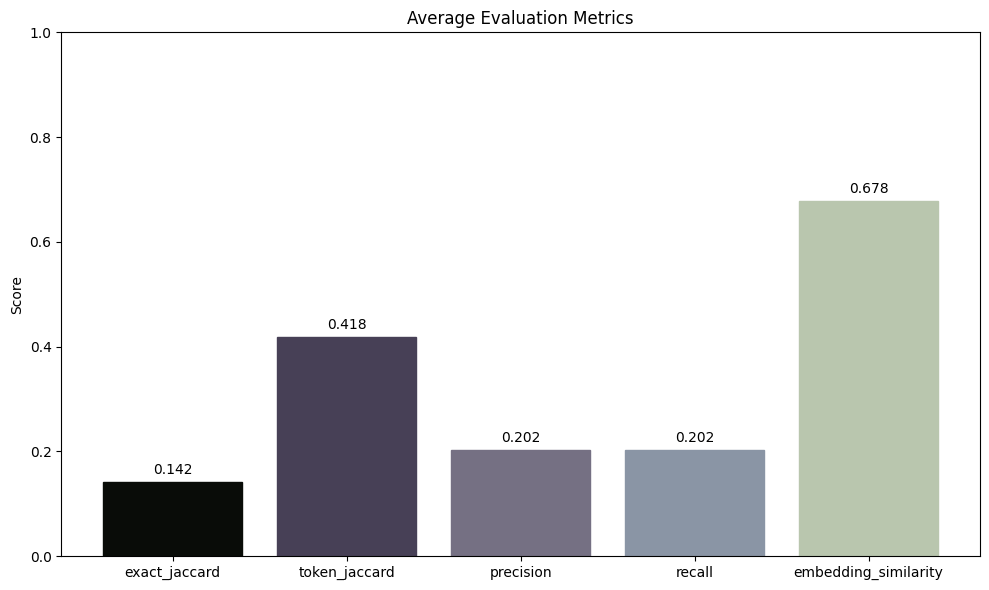

In [62]:
# Plotting the averages as a colorful bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(averages.keys(), averages.values())

# Add colors
colors = ['#090C08', '#474056', '#757083', '#8A95A5', '#B9C6AE']
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.3f}", ha='center', va='bottom')

plt.title("Average Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## **Deploying our GPT-3.5-turbo fine-tuned model**

In [58]:
def get_themes_from_model(poem, model_name):
    prompt = (
        f"For the poem below, give me 5 symbolism themes as a JSON list.\n\n"
        f"\"{poem}\"\n\n"
        "Respond ONLY with a JSON array of themes, no explanations needed. "
        "Example: [\"theme1\", \"theme2\", \"theme3\", \"theme4\", \"theme5\"]"
    )

    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that extracts symbolism themes from poems."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=300,
    )

    try:
        return json.loads(response.choices[0].message.content)
    except json.JSONDecodeError:
        return ["no_theme"] * 5

***Personal poem***

In [59]:
poem = "empty prayers, empty truth, empty faith. dying hope, i no longer said his name. but he found me and said he loved me just the same because it was the day true love bloomed. no, it had always been that way"

themes_3_5 = get_themes_from_model(poem, "ft:gpt-3.5-turbo-0125:personal::C15qtfQm")
themes_4_1 = get_themes_from_model(poem, "gpt-4.1-mini")

print("Fine-Tuned GPT-3.5-turbo Themes:", themes_3_5)
print("GPT-4.1-mini Themes:", themes_4_1)

Fine-Tuned GPT-3.5-turbo Themes: ['emptiness', 'faith and doubt', 'hope and despair', "love's persistence", 'truth and perception']
GPT-4.1-mini Themes: ['emptiness and despair', 'lost and found love', 'enduring faith', 'renewal and blooming', 'unspoken connection']
